Case: Segmenting Small or Distant Objects
🔹 Hypothesis: YOLOv8-Seg will perform better
✅ Reason: YOLOv8 is optimized for detecting objects at various scales due to its feature pyramid network, making it better at segmenting small or distant objects.
❌ CLIPSeg Limitation: Since CLIPSeg relies on global visual-text alignment, it may struggle with small objects that lack distinct visual features.

🔬 How to Test:

Use a CDNET 2012 video where objects appear small (e.g., vehicles far from the camera).
Run both YOLOv8-Seg and CLIPSeg to segment the small objects.
Compare segmentation accuracy using IoU and qualitative results.
Expected Outcome:
YOLOv8-Seg should detect and segment small objects more accurately, while CLIPSeg may miss them or produce poor masks.

Load the Data (HIGHWAY)

In [1]:
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image

# Paths to dataset
VIDEO_FOLDER = "C:\\Users\\Lenovo\\Desktop\\comp-vison-chap1\\TP2\\data\\baseline\\highway"  
INPUT_FOLDER = os.path.join(VIDEO_FOLDER, "input")
RESULTS_FOLDER = os.path.join(VIDEO_FOLDER, "results")
GROUNDTRUTH_FOLDER = os.path.join(VIDEO_FOLDER, "groundtruth")
TEMPORAL_ROI_FILE = os.path.join(VIDEO_FOLDER, "temporalROI.txt")

#temporal ROI:
with open(TEMPORAL_ROI_FILE, "r") as f:
    start_frame, end_frame = map(int, f.readline().split())

input_images = sorted([img for img in os.listdir(INPUT_FOLDER) if img.endswith(".jpg")])[start_frame-1:end_frame]

os.makedirs(RESULTS_FOLDER, exist_ok=True)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


YOLOv8

In [2]:
yolo_model = YOLO("yolov8n-seg.pt")  # Or "yolov8m-seg.pt"

def apply_yolo_segmentation(image_path):
    image = cv2.imread(image_path)
    results = yolo_model(image)[0] 

    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    if results.masks is not None:
        for mask_data in results.masks.xy:
            cv2.fillPoly(mask, [np.array(mask_data, dtype=np.int32)], 255)

    return mask



CLIPseg

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

def apply_clipseg(image_path, text_prompt="vehicules"):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512), Image.LANCZOS) 

    inputs = processor(text=[text_prompt], images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = clipseg_model(**inputs)

    mask = outputs.logits.squeeze().cpu().numpy()

    plt.imshow(mask, cmap="viridis")
    plt.colorbar()
    plt.title(f"CLIPSeg Raw Mask for {text_prompt}")
    plt.show()

    mask = (mask > 0.3).astype(np.uint8) * 255 

    return mask



Experement

In [ ]:
for i, image_name in enumerate(input_images):
    image_path = os.path.join(INPUT_FOLDER, image_name)
    save_path_yolo = os.path.join(RESULTS_FOLDER, f"bin{image_name[2:]}")  # Output format: bin000470.bmp
    save_path_clipseg = os.path.join(RESULTS_FOLDER, f"clip_{image_name[2:]}")  # CLIPSeg output


    yolo_mask = apply_yolo_segmentation(image_path)
    cv2.imwrite(save_path_yolo, yolo_mask)


    clipseg_mask = apply_clipseg(image_path, "vehicles")  # Modify text prompt as needed
    cv2.imwrite(save_path_clipseg, clipseg_mask)

    if i % 200 == 0:
        print(f"Processed {i+1}/{len(input_images)} frames...")


Step 1: Import Necessary Libraries

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


VIDEO_FOLDER = "C:\\Users\\Lenovo\\Desktop\\comp-vison-chap1\\TP2\\data\\baseline\\highway"
RESULTS_FOLDER = os.path.join(VIDEO_FOLDER, "results")
GROUNDTRUTH_FOLDER = os.path.join(VIDEO_FOLDER, "groundtruth")
TEMPORAL_ROI_FILE = os.path.join(VIDEO_FOLDER, "temporalROI.txt")

with open(TEMPORAL_ROI_FILE, "r") as f:
    start_frame, end_frame = map(int, f.readline().split())


input_images = sorted([img for img in os.listdir(os.path.join(VIDEO_FOLDER, "input")) if img.endswith(".jpg")])[start_frame-1:end_frame]


Step 2: Load Ground Truth Files

In [12]:
# Function to get correct ground truth
def get_groundtruth_path(image_name):
    base_name = f"gt{image_name[2:]}"
    for ext in [".png", ".bmp", ".jpg"]:
        path = os.path.join(GROUNDTRUTH_FOLDER, base_name.replace(".jpg", ext))
        if os.path.exists(path):
            return path
    raise FileNotFoundError(f"Ground truth file not found for {image_name}")


Step 3: Compute IoU

In [13]:
def calculate_iou(pred_mask, gt_mask):
    pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    pred_mask = (pred_mask > 127).astype(np.uint8)
    gt_mask = (gt_mask > 127).astype(np.uint8)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    
    return intersection / union if union > 0 else 0


Step 4: Compute IoU & Visualize Results

In [14]:
iou_scores_yolo = []
iou_scores_clipseg = []
selected_images = []

for i, image_name in enumerate(input_images):
    
    yolo_path = os.path.join(RESULTS_FOLDER, f"bin{image_name[2:]}")
    clipseg_path = os.path.join(RESULTS_FOLDER, f"clip_{image_name[2:]}")

    
    if not os.path.exists(yolo_path) or not os.path.exists(clipseg_path):
        print(f"Skipping {image_name} (Missing predictions)")
        continue

    
    yolo_pred = cv2.imread(yolo_path, 0)
    clipseg_pred = cv2.imread(clipseg_path, 0)

    try:
        gt_mask = cv2.imread(get_groundtruth_path(image_name), 0)
    except FileNotFoundError as e:
        print(e)
        continue

    
    yolo_pred = cv2.resize(yolo_pred, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    clipseg_pred = cv2.resize(clipseg_pred, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    
    iou_scores_yolo.append(calculate_iou(yolo_pred, gt_mask))
    iou_scores_clipseg.append(calculate_iou(clipseg_pred, gt_mask))

    # Save some images for visualization
    if i % 100 == 0:
        selected_images.append((image_name, yolo_pred, clipseg_pred, gt_mask))


print(f"YOLOv8 Average IoU: {np.mean(iou_scores_yolo):.3f}")
print(f"CLIPSeg Average IoU: {np.mean(iou_scores_clipseg):.3f}")


YOLOv8 Average IoU: 0.767
CLIPSeg Average IoU: 0.503


 Step 5: Display Sample Segmentations

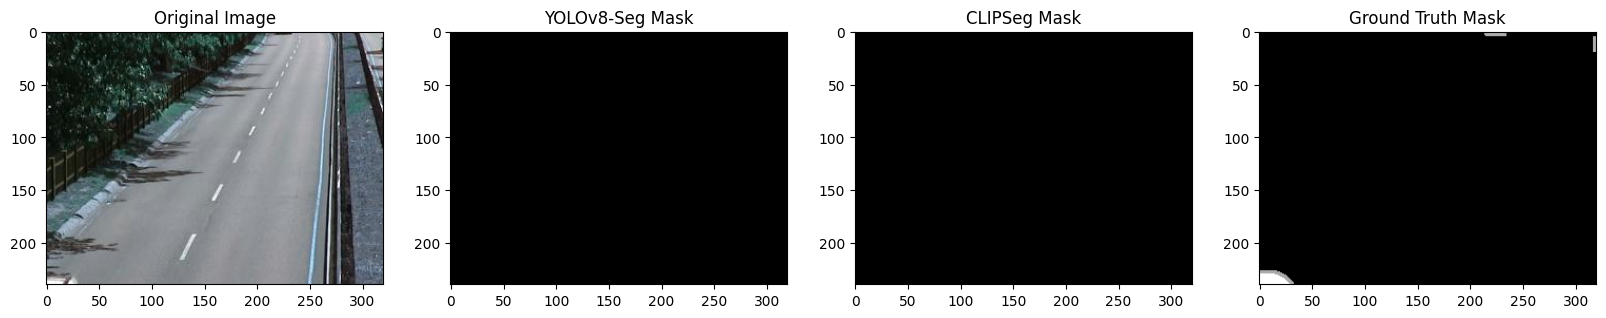

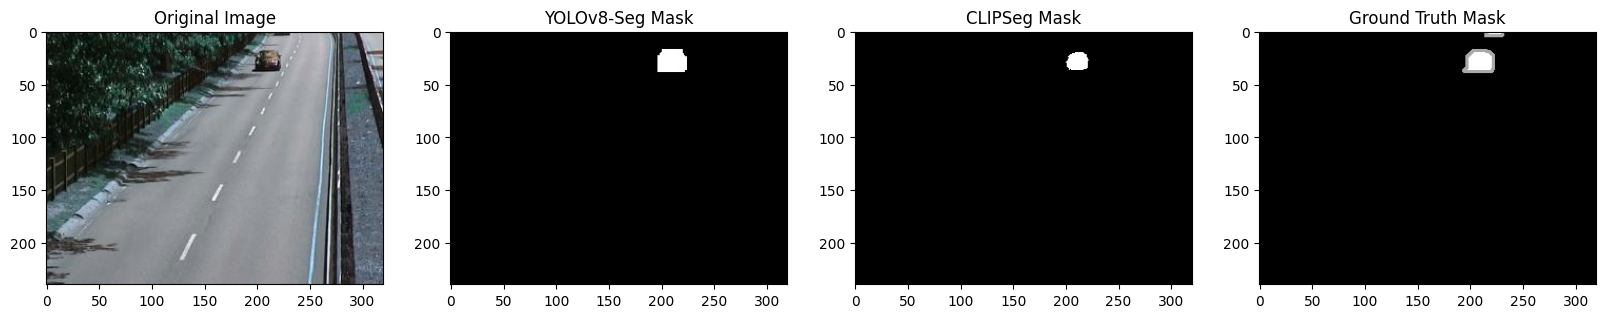

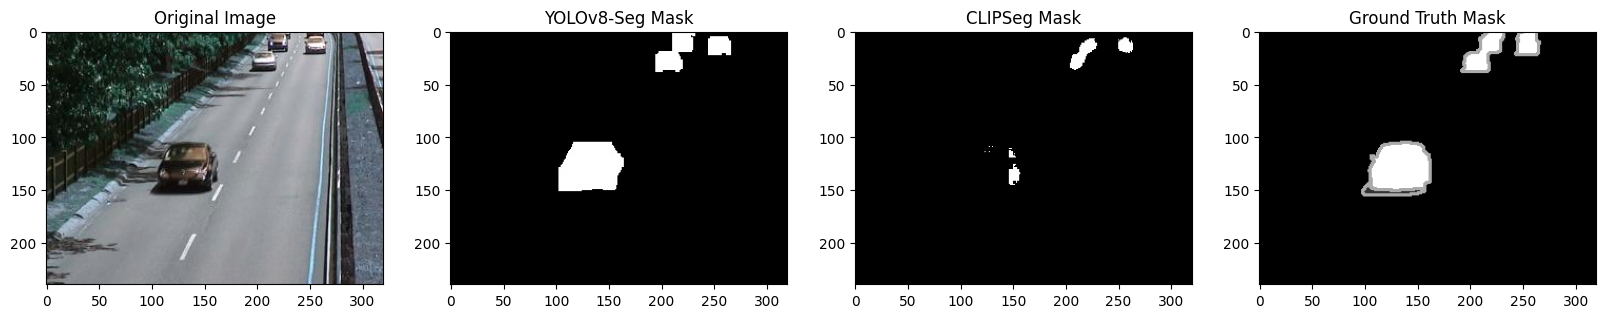

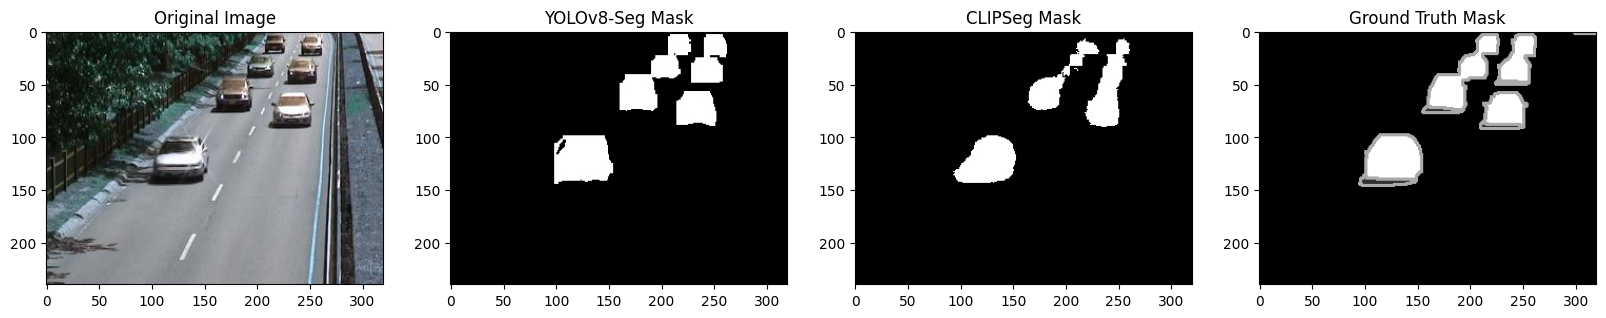

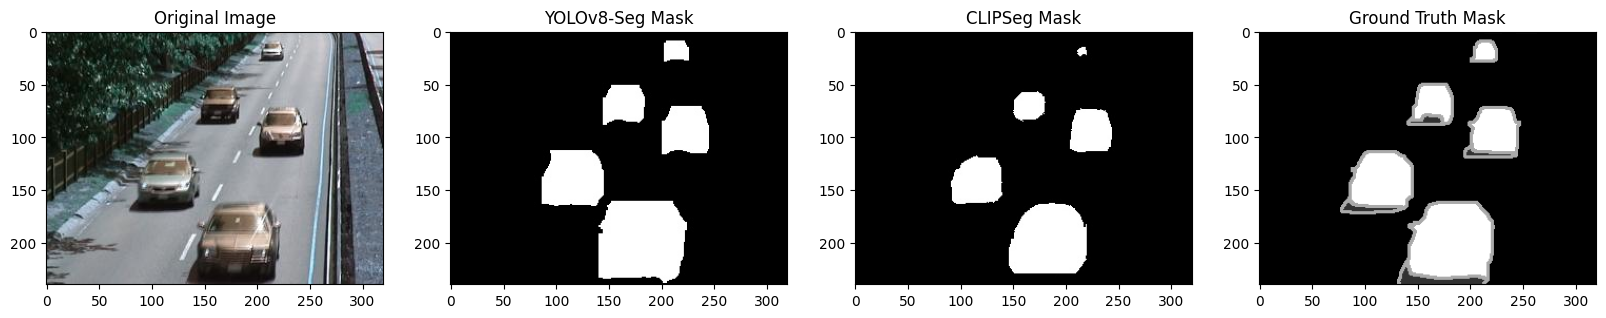

In [15]:
def show_results(image_name, yolo_mask, clipseg_mask, gt_mask):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(cv2.imread(os.path.join(VIDEO_FOLDER, "input", image_name)), cmap="gray")
    axes[0].set_title("Original Image")

    axes[1].imshow(yolo_mask, cmap="gray")
    axes[1].set_title("YOLOv8-Seg Mask")

    axes[2].imshow(clipseg_mask, cmap="gray")
    axes[2].set_title("CLIPSeg Mask")

    axes[3].imshow(gt_mask, cmap="gray")
    axes[3].set_title("Ground Truth Mask")

    plt.show()


for img_name, yolo, clipseg, gt in selected_images[:5]:  
    show_results(img_name, yolo, clipseg, gt)


Step 6: Generate IoU Distribution Plot

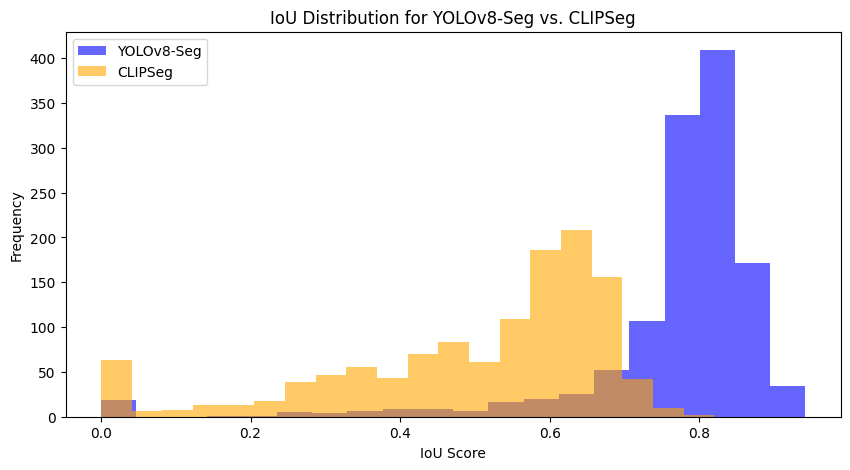

In [16]:
plt.figure(figsize=(10, 5))
plt.hist(iou_scores_yolo, bins=20, alpha=0.6, label="YOLOv8-Seg", color="blue")
plt.hist(iou_scores_clipseg, bins=20, alpha=0.6, label="CLIPSeg", color="orange")
plt.xlabel("IoU Score")
plt.ylabel("Frequency")
plt.title("IoU Distribution for YOLOv8-Seg vs. CLIPSeg")
plt.legend()
plt.show()


Step 7: Bar Chart for Average IoU Comparison

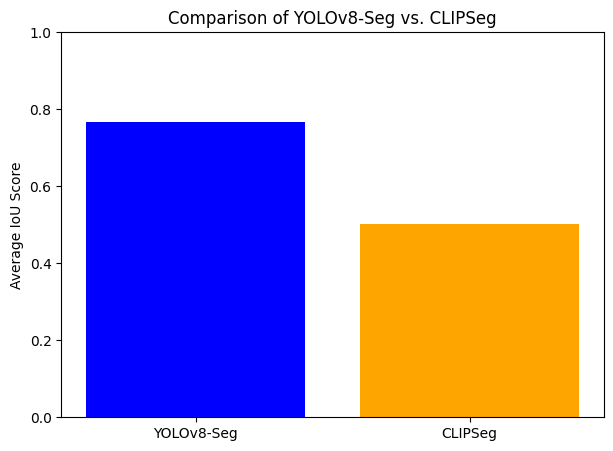

In [17]:
models = ["YOLOv8-Seg", "CLIPSeg"]
iou_means = [np.mean(iou_scores_yolo), np.mean(iou_scores_clipseg)]

plt.figure(figsize=(7, 5))
plt.bar(models, iou_means, color=["blue", "orange"])
plt.ylim(0, 1)  # IoU ranges from 0 to 1
plt.ylabel("Average IoU Score")
plt.title("Comparison of YOLOv8-Seg vs. CLIPSeg")
plt.show()


Step 8: Define Precision, Recall, and F1-score Calculation

In [18]:
def calculate_metrics(pred_mask, gt_mask):
    pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    pred_mask = (pred_mask > 127).astype(np.uint8)
    gt_mask = (gt_mask > 127).astype(np.uint8)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    true_positive = intersection
    false_positive = pred_mask.sum() - true_positive 
    false_negative = gt_mask.sum() - true_positive  

    
    iou = intersection / union if union > 0 else 0
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return iou, precision, recall, f1_score


Step 9: Compute Metrics for YOLOv8-Seg and CLIPSeg

In [19]:

iou_scores_yolo, precision_yolo, recall_yolo, f1_scores_yolo = [], [], [], []
iou_scores_clipseg, precision_clipseg, recall_clipseg, f1_scores_clipseg = [], [], [], []

for image_name in input_images:
    yolo_path = os.path.join(RESULTS_FOLDER, f"bin{image_name[2:]}")
    clipseg_path = os.path.join(RESULTS_FOLDER, f"clip_{image_name[2:]}")

    if not os.path.exists(yolo_path) or not os.path.exists(clipseg_path):
        print(f"Skipping {image_name} (Missing predictions)")
        continue


    yolo_pred = cv2.imread(yolo_path, 0)
    clipseg_pred = cv2.imread(clipseg_path, 0)

    try:
        gt_mask = cv2.imread(get_groundtruth_path(image_name), 0)
    except FileNotFoundError as e:
        print(e)
        continue

    
    yolo_pred = cv2.resize(yolo_pred, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    clipseg_pred = cv2.resize(clipseg_pred, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # metrics
    iou_yolo, prec_yolo, rec_yolo, f1_yolo = calculate_metrics(yolo_pred, gt_mask)
    iou_clip, prec_clip, rec_clip, f1_clip = calculate_metrics(clipseg_pred, gt_mask)

    
    iou_scores_yolo.append(iou_yolo)
    precision_yolo.append(prec_yolo)
    recall_yolo.append(rec_yolo)
    f1_scores_yolo.append(f1_yolo)

    iou_scores_clipseg.append(iou_clip)
    precision_clipseg.append(prec_clip)
    recall_clipseg.append(rec_clip)
    f1_scores_clipseg.append(f1_clip)


print(f"\nYOLOv8 Average Metrics:")
print(f"IoU: {np.mean(iou_scores_yolo):.3f}, Precision: {np.mean(precision_yolo):.3f}, Recall: {np.mean(recall_yolo):.3f}, F1-score: {np.mean(f1_scores_yolo):.3f}")

print(f"\nCLIPSeg Average Metrics:")
print(f"IoU: {np.mean(iou_scores_clipseg):.3f}, Precision: {np.mean(precision_clipseg):.3f}, Recall: {np.mean(recall_clipseg):.3f}, F1-score: {np.mean(f1_scores_clipseg):.3f}")



YOLOv8 Average Metrics:
IoU: 0.767, Precision: 0.945, Recall: 0.795, F1-score: 0.858

CLIPSeg Average Metrics:
IoU: 0.503, Precision: 0.930, Recall: 0.511, F1-score: 0.645


Step 10: Generate Comparison Plots

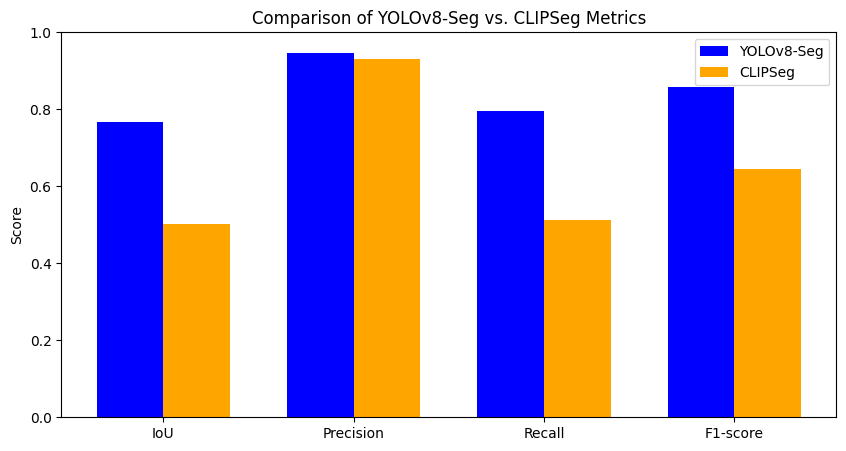

In [20]:
metrics = ["IoU", "Precision", "Recall", "F1-score"]
yolo_means = [np.mean(iou_scores_yolo), np.mean(precision_yolo), np.mean(recall_yolo), np.mean(f1_scores_yolo)]
clipseg_means = [np.mean(iou_scores_clipseg), np.mean(precision_clipseg), np.mean(recall_clipseg), np.mean(f1_scores_clipseg)]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, yolo_means, width, label="YOLOv8-Seg", color="blue")
plt.bar(x + width/2, clipseg_means, width, label="CLIPSeg", color="orange")

plt.xticks(ticks=x, labels=metrics)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Comparison of YOLOv8-Seg vs. CLIPSeg Metrics")
plt.legend()
plt.show()
